<a href="https://colab.research.google.com/github/tanushreevijay/Coding-club/blob/main/ColdChainGuard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-14-2145366832.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  timestamps = pd.date_range("2023-01-01", periods=hours, freq="H")
/tmp/ipython-input-14-2145366832.py:69: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['lag_temp_1h'] = df['temperature'].shift(1).fillna(method='bfill')


Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       125
           1       0.52      0.68      0.59        19

    accuracy                           0.88       144
   macro avg       0.73      0.79      0.76       144
weighted avg       0.89      0.88      0.88       144



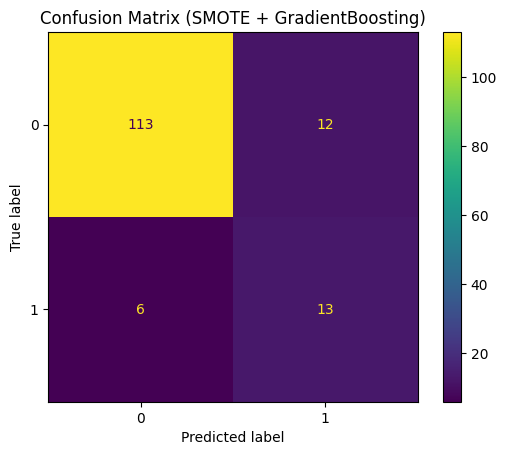


Feature Importances:
ambient_temp: 0.007
hour: 0.016
power_cut: 0.000
rolling_mean: 0.585
rolling_std: 0.062
delta_temp: 0.037
lag_temp_1h: 0.030
temp_diff: 0.262


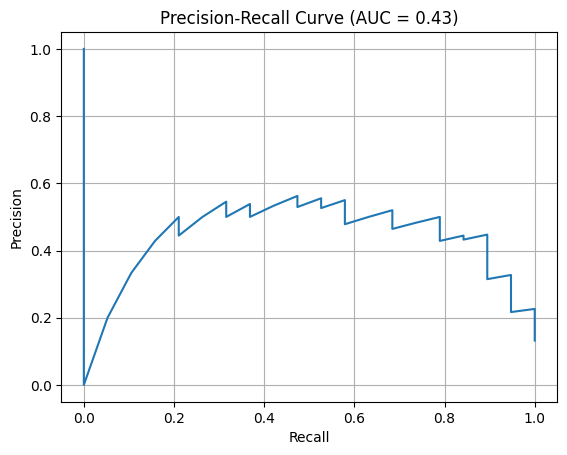


Unsupervised Learning (Isolation Forest):

Anomaly Detection Performance vs True Labels:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       625
           1       0.53      0.60      0.56        95

    accuracy                           0.88       720
   macro avg       0.73      0.76      0.74       720
weighted avg       0.88      0.88      0.88       720


Saved trained model to models/coldchain_spoilage_model.pkl


In [ ]:
# ✅ UPDATED SIMULATION & MODEL: Realistic Cold Chain Spoilage Detection (Enhanced Feature + Label Dynamics)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, IsolationForest, GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import joblib
import os

# ------------------------
# 🧊 1. Simulate Realistic Data with Stronger Spoilage Signals
# ------------------------
def simulate_improved_coldchain(hours=720, upper=8, lower=2):
    np.random.seed(42)
    timestamps = pd.date_range("2023-01-01", periods=hours, freq="H")
    temp, label, ambient_temp, power_cut_flags = [], [], [], []
    spoilage_flags = [0]*hours

    for i in range(hours):
        amb = 30 + 12 * np.sin(np.pi * (i % 24) / 12) + np.random.normal(0, 1)
        ambient_temp.append(amb)

        is_power_cut = np.random.rand() < 0.12
        power_cut_flags.append(is_power_cut)

        if i % 100 == 0:
            for j in range(i, min(i + 6, hours)):
                spoilage_flags[j] = 1

        if spoilage_flags[i]:
            base_temp = np.random.uniform(8.5, 11)
        elif is_power_cut:
            base_temp = min(amb, 15)
        else:
            base_temp = np.random.uniform(2.5, 5.5)

        actual_temp = base_temp + np.random.normal(0, 0.3)
        temp.append(actual_temp)

        if spoilage_flags[i]:
            label.append(1 if np.random.rand() < 0.9 else 0)
        elif actual_temp > upper or actual_temp < lower:
            label.append(1 if np.random.rand() < 0.5 else 0)
        else:
            label.append(1 if np.random.rand() < 0.02 else 0)

    return pd.DataFrame({
        "timestamp": timestamps,
        "ambient_temp": ambient_temp,
        "temperature": temp,
        "label": label,
        "power_cut": power_cut_flags
    })

# Generate Data
df = simulate_improved_coldchain()

# ------------------------
# 📊 2. Feature Engineering (with Temporal Signals)
# ------------------------
df['hour'] = df['timestamp'].dt.hour

df['rolling_mean'] = df['temperature'].rolling(3).mean().bfill()
df['rolling_std'] = df['temperature'].rolling(3).std().bfill()
df['delta_temp'] = df['ambient_temp'] - df['temperature']
df['lag_temp_1h'] = df['temperature'].shift(1).fillna(method='bfill')
df['temp_diff'] = df['temperature'] - df['lag_temp_1h']

features = ['ambient_temp', 'hour', 'power_cut', 'rolling_mean', 'rolling_std', 'delta_temp', 'lag_temp_1h', 'temp_diff']
X = df[features]
y = df['label']

# ------------------------
# 🤖 3. Train Model with SMOTE Resampling (Gradient Boosting)
# ------------------------
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

clf = GradientBoostingClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)
y_pred = clf.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# ------------------------
# 📉 4. Confusion Matrix & Feature Importance
# ------------------------
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.title("Confusion Matrix (SMOTE + GradientBoosting)")
plt.grid(False)
plt.show()

print("\nFeature Importances:")
for feat, score in zip(features, clf.feature_importances_):
    print(f"{feat}: {score:.3f}")

# ------------------------
# 📈 5. PR Curve
# ------------------------
from sklearn.metrics import precision_recall_curve
probs = clf.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)

plt.plot(recall, precision)
plt.title(f"Precision-Recall Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

# ------------------------
# 🧪 6. Anomaly Detection (Isolation Forest + Tuned Threshold)
# ------------------------
print("\nUnsupervised Learning (Isolation Forest):")
X_unsupervised = X[y == 0]
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_unsupervised)

scores = iso_forest.decision_function(X)
threshold = np.percentile(scores, 15)
df['anomaly_label'] = (scores < threshold).astype(int)

print("\nAnomaly Detection Performance vs True Labels:")
print(classification_report(df['label'], df['anomaly_label']))

# ------------------------
# 💾 7. Export Model for Deployment
# ------------------------
os.makedirs("models", exist_ok=True)
joblib.dump(clf, "models/coldchain_spoilage_model.pkl")
print("\nSaved trained model to models/coldchain_spoilage_model.pkl")


Classification Report (Current Spoilage):
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       124
           1       0.60      0.79      0.68        19

    accuracy                           0.90       143
   macro avg       0.78      0.85      0.81       143
weighted avg       0.92      0.90      0.91       143



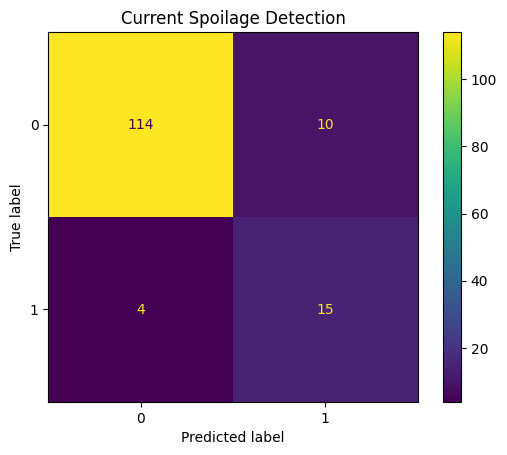


Classification Report (6-hour Forecast):
              precision    recall  f1-score   support

         0.0       0.90      0.75      0.82       125
         1.0       0.18      0.39      0.25        18

    accuracy                           0.71       143
   macro avg       0.54      0.57      0.53       143
weighted avg       0.81      0.71      0.75       143



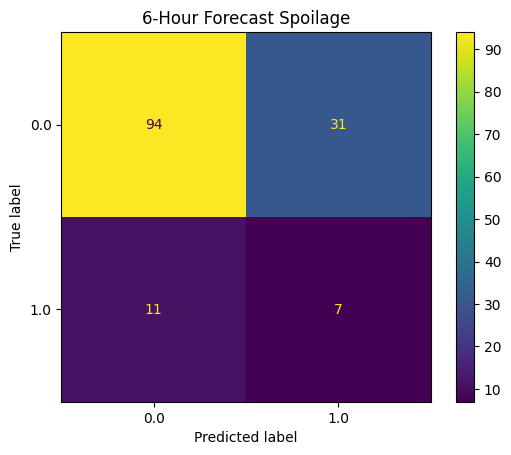


Unsupervised Learning (Isolation Forest):

Anomaly Detection Performance vs True Labels:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       619
           1       0.52      0.59      0.55        95

    accuracy                           0.87       714
   macro avg       0.73      0.75      0.74       714
weighted avg       0.88      0.87      0.88       714


✅ Saved models to 'models/' folder


/tmp/ipython-input-3-544397644.py:159: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


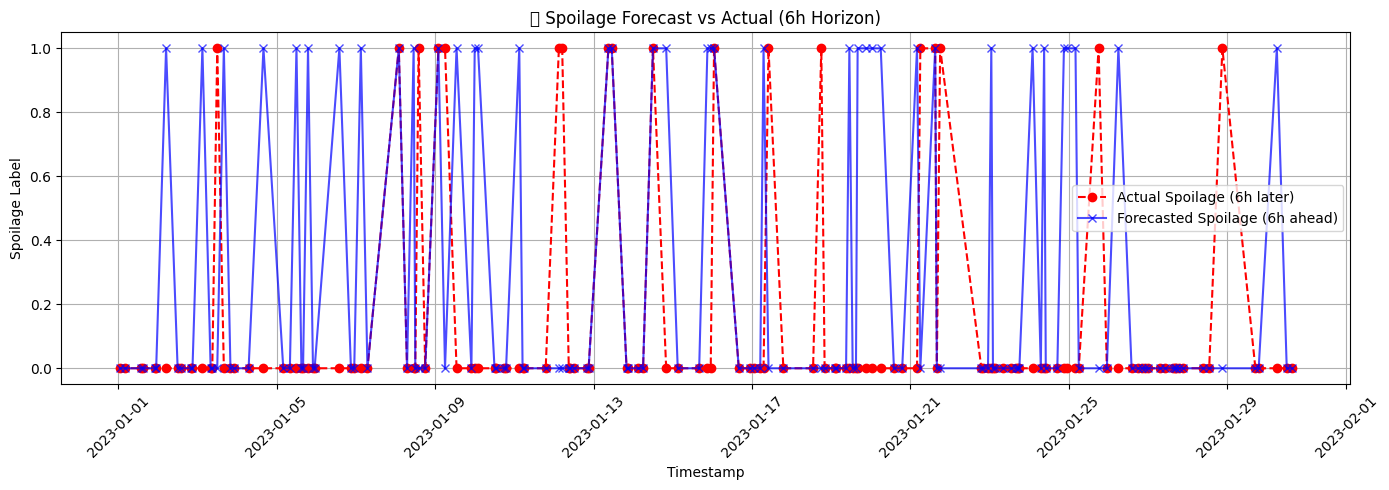

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import joblib
import os

# ------------------------
# 1. Simulate Cold Chain Data
# ------------------------
def simulate_improved_coldchain(hours=720, upper=8, lower=2):
    np.random.seed(42)
    timestamps = pd.date_range("2023-01-01", periods=hours, freq="h")
    temp, label, ambient_temp, power_cut_flags = [], [], [], []
    spoilage_flags = [0]*hours

    for i in range(hours):
        amb = 30 + 12 * np.sin(np.pi * (i % 24) / 12) + np.random.normal(0, 1)
        ambient_temp.append(amb)

        is_power_cut = np.random.rand() < 0.12
        power_cut_flags.append(is_power_cut)

        if i % 100 == 0:
            for j in range(i, min(i + 6, hours)):
                spoilage_flags[j] = 1

        if spoilage_flags[i]:
            base_temp = np.random.uniform(8.5, 11)
        elif is_power_cut:
            base_temp = min(amb, 15)
        else:
            base_temp = np.random.uniform(2.5, 5.5)

        actual_temp = base_temp + np.random.normal(0, 0.3)
        temp.append(actual_temp)

        if spoilage_flags[i]:
            label.append(1 if np.random.rand() < 0.9 else 0)
        elif actual_temp > upper or actual_temp < lower:
            label.append(1 if np.random.rand() < 0.5 else 0)
        else:
            label.append(1 if np.random.rand() < 0.02 else 0)

    return pd.DataFrame({
        "timestamp": timestamps,
        "ambient_temp": ambient_temp,
        "temperature": temp,
        "label": label,
        "power_cut": power_cut_flags
    })

df = simulate_improved_coldchain()

# ------------------------
# 2. Feature Engineering
# ------------------------
df['hour'] = df['timestamp'].dt.hour
df['rolling_mean'] = df['temperature'].rolling(3).mean().bfill()
df['rolling_std'] = df['temperature'].rolling(3).std().bfill()
df['delta_temp'] = df['ambient_temp'] - df['temperature']
df['lag_temp_1h'] = df['temperature'].shift(1).bfill()
df['temp_diff'] = df['temperature'] - df['lag_temp_1h']

# Forecast label: spoilage 6 hours into the future
forecast_horizon = 6
df['future_spoilage'] = df['label'].shift(-forecast_horizon)
df.dropna(inplace=True)

features = ['ambient_temp', 'hour', 'power_cut', 'rolling_mean', 'rolling_std', 'delta_temp', 'lag_temp_1h', 'temp_diff']
X = df[features]
y_current = df['label']
y_future = df['future_spoilage']

# ------------------------
# 3. Model Training - Current Spoilage
# ------------------------
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(X, y_current):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_current.iloc[train_idx], y_current.iloc[test_idx]

X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)
clf_current = GradientBoostingClassifier(n_estimators=150, random_state=42)
clf_current.fit(X_resampled, y_resampled)
y_pred = clf_current.predict(X_test)

print("\nClassification Report (Current Spoilage):")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(clf_current, X_test, y_test)
plt.title("Current Spoilage Detection")
plt.grid(False)
plt.show()

# ------------------------
# 4. Model Training - Forecasted Spoilage
# ------------------------
for train_idx, test_idx in split.split(X, y_future):
    Xf_train, Xf_test = X.iloc[train_idx], X.iloc[test_idx]
    yf_train, yf_test = y_future.iloc[train_idx], y_future.iloc[test_idx]

Xf_resampled, yf_resampled = SMOTE().fit_resample(Xf_train, yf_train)
clf_forecast = GradientBoostingClassifier(n_estimators=150, random_state=42)
clf_forecast.fit(Xf_resampled, yf_resampled)
yf_pred = clf_forecast.predict(Xf_test)

print("\nClassification Report (6-hour Forecast):")
print(classification_report(yf_test, yf_pred))
ConfusionMatrixDisplay.from_estimator(clf_forecast, Xf_test, yf_test)
plt.title("6-Hour Forecast Spoilage")
plt.grid(False)
plt.show()

# ------------------------
# 5. Anomaly Detection
# ------------------------
print("\nUnsupervised Learning (Isolation Forest):")
X_unsupervised = X[y_current == 0]
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_unsupervised)

scores = iso_forest.decision_function(X)
threshold = np.percentile(scores, 15)
df['anomaly_label'] = (scores < threshold).astype(int)

print("\nAnomaly Detection Performance vs True Labels:")
print(classification_report(df['label'], df['anomaly_label']))

# ------------------------
# 6. Save Trained Models
# ------------------------
os.makedirs("models", exist_ok=True)
joblib.dump(clf_current, "models/coldchain_spoilage_model.pkl")
joblib.dump(clf_forecast, "models/coldchain_forecast_model.pkl")
print("\n✅ Saved models to 'models/' folder")

# ------------------------
# 7. Visual Plot: Forecast vs Actual
# ------------------------

# Merge for plotting
plot_df = df.iloc[Xf_test.index].copy()
plot_df['predicted_spoilage_6h'] = yf_pred
plot_df = plot_df.sort_values('timestamp').reset_index(drop=True)

# Plot forecasted vs actual spoilage
plt.figure(figsize=(14, 5))
plt.plot(plot_df['timestamp'], plot_df['future_spoilage'], label='Actual Spoilage (6h later)', color='red', linestyle='--', marker='o')
plt.plot(plot_df['timestamp'], plot_df['predicted_spoilage_6h'], label='Forecasted Spoilage (6h ahead)', color='blue', alpha=0.7, marker='x')
plt.title("📉 Spoilage Forecast vs Actual (6h Horizon)")
plt.xlabel("Timestamp")
plt.ylabel("Spoilage Label")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

